## **Agrupando Clientes por Padrão de Consumo**

![](img/energy1.jpg)

### **INTRODUÇÃO**

As empresas sempre estão em busca de encontrar meios para promover seus produtos, aumentar o número de clientes e, consequentemente, obter maiores lucros. É fato que cada pessoa tem um gosto singular, em sua essência, em relação aos produtos e serviços que lhes são oferecidos. Definir estratégias para alcançar cada tipo de cliente é algo que mudaria profundamente a dinâmica de um negócio e um passo além dos concorrentes.

A segmentação, ou agrupamento, é um processo estratégico em que clientes e potenciais clientes passam a fazer parte de determinados grupos com características semelhantes de comportamento/gostos. Por exemplo, grupo de mulheres que gostam de ir à academia; dessas que vão à academia, as que têm entre 18 e 25 anos; pessoas que andam de bicicleta na orla de Boa Viagem (PE); das que andam de bicicleta, as que vão pela manhã; etc. E assim criar algo personalizado a oferecer.

As possibilidades são inúmeras. Os objetivos estratégicos para atingir esses grupos também. De quê adianta a *Companhia de Leitores de Ficção* querer vender seus livros para grupos de pessoas que leem APENAS romance? Ninguém compraria. O foco seria divergente e haveria desperdício de recursos. Não há empresa no mundo que goste de um prejuízo, não é verdade?

Essa é a ideia geral de um agrupamento.

As soluções não se limitam a vendas de produtos e personalização de serviços para determinados grupos de clientes. Mas essa solução também pode ser aplicada em estudos para entender, por exemplo, o  consumo de energia em determinados horários, sem a necessidade de oferecer serviços - mas (por que não?) campanhas de conscientização.

### **OBJETIVO**

Uma Cia Elétrica detém um grande número de dados sobre o consumo de energia dos cidadãos de uma região. Com base nesses dados, a empresa pediu para <b>agrupar os consumidores por similaridade a fim de compreender o comportamento dos clientes e sua relação com o consumo de energia</b>.

**Dicionário de Atributos**
1. `date`: Data no formato dd/mm/yyyy
2. `time`: Tempo no formato hh:mm:ss
3. `global_active_power`: Energia ativa média global por família (em kilowatt)
4. `global_reactive_power`: Energia reativa média global por família (em kilowatt)
5. `voltage`: Voltagem média (em volt)
6. `global_intensity`: Intensidade global da corrente por família (em ampere)
7. `sub_metering_1`: Sub-divisão da energia No. 1 (em watt-hora por energia ativa). Corresponde à cozinha, contendo principalmente lava-louça, fogão e microondas.
8. `sub_metering_2`: Sub-divisão da energia No. 2 (em watt-hora por energia ativa). Corresponde à lavanderia, contendo principalmente máquina de lavar, secadora, refrigerador e iluminação.
9. `sub_metering_3`: Sub-divisão da energia No. 3 (em watt-hora por energia ativa). Corresponde ao aquecedor de água e arcondicionado.

### **IMPORTANDO PACOTES E CARREGANDO DATASET**

In [2]:
  # Importação dos pacotes
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist, pdist

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [202]:
consumo_energia = pd.read_table('~/Mega/Portfolio/dataset/cluster/dataset_power_consumption.txt', delimiter=';')

### **ANÁLISE EXPLORATÓRIA E MANIPULAÇÃO DE DADOS**

> **1. Verificar um exemplo do conjunto de dados**

Observar uma amostra contendo cinco linhas do dataset para saber como estão dispostos os dados.

Em seguida analisar os tipos e a quantidade de dados carregados.

In [203]:
# Cinco amostras
consumo_energia.sample(5)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
110616,3/3/2007,13:00:00,1.286,0.000,240.950,5.200,0.000,0.000,18.0
1278312,22/5/2009,10:36:00,0.332,0.116,242.150,1.400,0.000,1.000,1.0
13212,25/12/2006,21:36:00,4.516,0.000,236.850,19.000,1.000,36.000,17.0
1139330,14/2/2009,22:14:00,1.628,0.090,242.580,6.600,0.000,0.000,18.0
946218,3/10/2008,19:42:00,4.144,0.242,233.710,18.000,27.000,0.000,17.0


In [204]:
# Tipos e quantidade de dados
consumo_energia.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   2075259 non-null  object 
 1   Time                   2075259 non-null  object 
 2   Global_active_power    2075259 non-null  object 
 3   Global_reactive_power  2075259 non-null  object 
 4   Voltage                2075259 non-null  object 
 5   Global_intensity       2075259 non-null  object 
 6   Sub_metering_1         2075259 non-null  object 
 7   Sub_metering_2         2075259 non-null  object 
 8   Sub_metering_3         2049280 non-null  float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


**Observação 1**: Aparentemente, olhando apenas para as cinco amostras, notamos que não existem valores que se mostrem estranhos/formatados de forma irregular.

**Observação 2**: São 2075259 linhas e 9 colunas, onde todos os atributos estão no formato 'object' *(salvo `['Sub_metering_3']` - tipo float).*

**Observação 3**: O atributo `['Sub_metering_3']` possui valores missing pois a quantidade de valores non-null *(não nulos)* é inferior ao restante dos atributos.

É importante saber que, para o processamento, os dados devem estar todos em formato numérico pois algoritmos de machine learning se dão melhor com esse formato.

> **2. Missing Values**

Encontrar valores NaN, sua proporção e tratar da forma mais adequada.

In [205]:
# Encontrar a quantidade de valores NaN
print('QUANTIDADE NAN')
print('--------------')
print(consumo_energia.isna().sum())

# Encontrar a proporção desses valores
print('\nPROPORÇÃO NAN')
print('-------------')
print(consumo_energia.isna().mean().sort_values(ascending=False)*100)

QUANTIDADE NAN
--------------
Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

PROPORÇÃO NAN
-------------
Sub_metering_3           1.251844
Sub_metering_2           0.000000
Sub_metering_1           0.000000
Global_intensity         0.000000
Voltage                  0.000000
Global_reactive_power    0.000000
Global_active_power      0.000000
Time                     0.000000
Date                     0.000000
dtype: float64


Encontramos *25979* registros com valores NaN no atributo `['Sub_metering_3']`, o que corresponde a *1,25%* do total de linhas.

Vamos imprimir as linhas onde existem valores NaN:

In [206]:
# Linhas com valores NaN
consumo_energia[consumo_energia['Sub_metering_3'].isna()]

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,21/12/2006,11:23:00,?,?,?,?,?,?,NaN
6840,21/12/2006,11:24:00,?,?,?,?,?,?,NaN
19724,30/12/2006,10:08:00,?,?,?,?,?,?,NaN
19725,30/12/2006,10:09:00,?,?,?,?,?,?,NaN
41832,14/1/2007,18:36:00,?,?,?,?,?,?,NaN
...,...,...,...,...,...,...,...,...,...
1990185,28/9/2010,19:09:00,?,?,?,?,?,?,NaN
1990186,28/9/2010,19:10:00,?,?,?,?,?,?,NaN
1990187,28/9/2010,19:11:00,?,?,?,?,?,?,NaN
1990188,28/9/2010,19:12:00,?,?,?,?,?,?,NaN


Como observado, além dos valores NaN, apareceu o caracter '?' em diversos registros em quase todos os atributos - o que indica a mesma coisa de valor NaN. Vamos trocar esse caracter por NaN, assim podemos analisar melhor a quantidade de NaN no dataset completo.

In [207]:
# Trocar caracter '?' por NaN
consumo_energia.replace('?', np.nan, inplace=True)

# Proporção dos valores NaN
consumo_energia.isna().mean().sort_values(ascending=True)

Date                     0.000000
Time                     0.000000
Global_active_power      0.012518
Global_reactive_power    0.012518
Voltage                  0.012518
Global_intensity         0.012518
Sub_metering_1           0.012518
Sub_metering_2           0.012518
Sub_metering_3           0.012518
dtype: float64

Há valores missing em todos os registros de cada atributo *(salvo `['Date', 'Time']`)*. Vamos removê-los.

In [208]:
# Deletar todas as linhas onde NaN se faz presente.
consumo_energia.dropna(axis=0, how='any', inplace=True)

# Quantidade de valores missing
print('Quantidade de valores NaN')
print('-------------------------')
print(consumo_energia.isna().sum())

# Dimensões do dataset
print('\nShape', consumo_energia.shape)

Quantidade de valores NaN
-------------------------
Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Shape (2049280, 9)


Com isso podemos verificar que existem 2049280 linhas disponíveis para trabalharmos rumo à resolução do problema definido, mas...

> **3. Coletar 2% do conjunto de dados**

Essa coleta percentual é devido ao peso computacional exigido e muitos de nós não detêm m'aquinas com grande capacidade de processamento. Esse 2% facilitará nossas vidas *(onde temos que ter, pelo menos, o mínimo de hardware ou utilização da computação em nuvem)* e teremos uma amostra significativa de dados. De agora em diante, será instanciado o objeto `power_consumption`.

In [209]:
# Coleta de 2% dos dados
power_consumption = consumo_energia.sample(frac=0.02, replace=False, random_state=42)
power_consumption.reset_index(inplace=True)
power_consumption.drop(columns='index', inplace=True)

# Dimensões dos dados segregados
print('SHAPE', power_consumption.shape)

# Proporcionalidade em relação aos dados originais
proportion = power_consumption.shape[0] / consumo_energia.shape[0]
print('PROPORTION: {0:.1f}%'.format(proportion*100))

SHAPE (40986, 9)
PROPORTION: 2.0%


A proporção de 2% nos retornou uma quantidade de linhas igual a 40986. O suficiente para continuarmos o trabalho.

Vamos rever as informações do dataset coletado. Vamos observar que os non-null estão todos iguais ao número de linhas. Então, sem valores missing.

In [58]:
# Infos da amostra coletada
power_consumption.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40986 entries, 0 to 40985
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   40986 non-null  object 
 1   Time                   40986 non-null  object 
 2   Global_active_power    40986 non-null  object 
 3   Global_reactive_power  40986 non-null  object 
 4   Voltage                40986 non-null  object 
 5   Global_intensity       40986 non-null  object 
 6   Sub_metering_1         40986 non-null  object 
 7   Sub_metering_2         40986 non-null  object 
 8   Sub_metering_3         40986 non-null  float64
dtypes: float64(1), object(8)
memory usage: 2.8+ MB


> **4. Remoção de atributos**

Ok. Nesse momento devemos perceber que, para a resolução do problema, não necessitamos dos dados de `['Date', Time']`. Vamos removê-los. Em seguida devemos transformar os tipos de dados para valores float.

In [210]:
# Remoção dos atributos 'Date' e 'Time'
power_consumption.drop(columns=['Date', 'Time'], inplace=True)

# Transformação tipo object em tipo float
power_consumption = power_consumption.astype('float64')

print(power_consumption.dtypes)

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [211]:
# Primeiras cinco linhas
power_consumption.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,1.502,0.074,240.17,6.4,0.0,0.0,18.0
1,0.374,0.264,245.50,1.8,0.0,2.0,0.0
2,0.620,0.300,239.85,3.0,0.0,1.0,1.0
3,0.280,0.200,235.72,1.4,0.0,0.0,0.0
4,1.372,0.054,243.95,5.6,0.0,0.0,18.0


> **7. Estatísticas, Gráficos e Outliers**

1. Estatística
2. Histogramas de atributos Global Active Power, Reactive Power e Global Intensity
3. Boxplot dos atributos

> *7.a. Estatística básica*

Abaixo segue uma tabela estatística básica com `contagem`, `média`, `desvio-padrão`, `valor mínimo`, `valor máximo` e `quartis`.



In [212]:
power_consumption.describe().round(3)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,40986.000,40986.000,40986.000,40986.000,40986.000,40986.000,40986.000
mean,1.098,0.125,240.843,4.654,1.167,1.280,6.533
std,1.059,0.113,3.243,4.449,6.277,5.752,8.475
min,0.076,0.000,225.900,0.200,0.000,0.000,0.000
25%,0.310,0.050,239.000,1.400,0.000,0.000,0.000
50%,0.613,0.102,241.020,2.600,0.000,0.000,1.000
75%,1.536,0.196,242.870,6.400,0.000,1.000,17.000
max,10.290,1.000,253.320,44.600,80.000,77.000,31.000


Da Estatística impressa acima, podemos observar alguns valores aparentemente fora do comum.

Observe que os valores correspondentes a 75% é bem inferior, em alguns casos, aos valores máximos. Isso pode represensar um *outlier*.

Para concluir melhor, uma representação gráfica é interessante. Porém se pararmos para pensar, os valores 0 nos atributos de `['Sub_metering']` podem não ser valores discrepantes, pode apenas ser que não tenha tais equipamentos englobados em cada `['Sub_metering']`.

Relembrando,<br>

* `['Sub_metering_1']` corresponde à cozinha (lava louças, fogão e microondas). Qual a casa que não tem pelo menos um fogão elétrico???? Nesse caso devem utilizar a lenha ou a gás??

* `['Sub_metering_2']` corresponde à lavanderia (máquina de lavar, de secar, refrigerador e iluminação). Creio que alguém viveria sem lavanderia 'elétrica'!

* `['Sub_metering_3']` corresponde ao aquecedor de água e arcondicionado. Com certeza existem lugares sem esses equipamentos!

Mas vamos olhar uns gráficos para ver a distribuição/intensidade desses valores.



>*6.b. Histrogrrama e Density Plot*

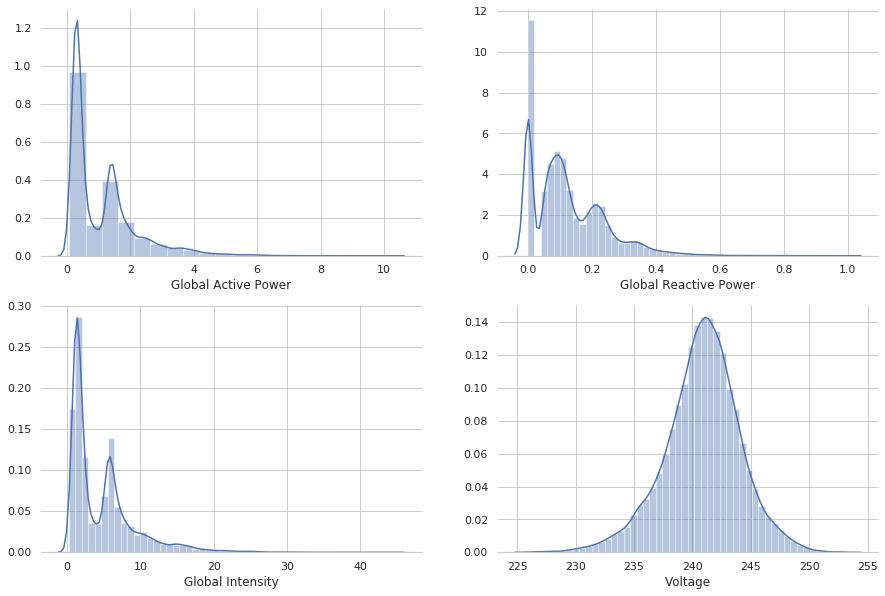

In [213]:
# Histogramas / Density Plot

GAP = power_consumption.Global_active_power
GRP = power_consumption.Global_reactive_power
GI = power_consumption.Global_intensity
VOLT = power_consumption.Voltage

fig, axes = plt.subplots(2,2, figsize=(15,10))
sns.despine(left=True)

sns.distplot(GAP, hist=True, ax=axes[0,0], bins=20, axlabel='Global Active Power')
sns.distplot(GRP, hist=True, ax=axes[0,1], axlabel='Global Reactive Power')
sns.distplot(GI, hist=True, ax=axes[1,0], axlabel='Global Intensity')
sns.distplot(VOLT, hist=True, ax=axes[1,1], axlabel='Voltage')


plt.show()

> *6.c. Boxplot*

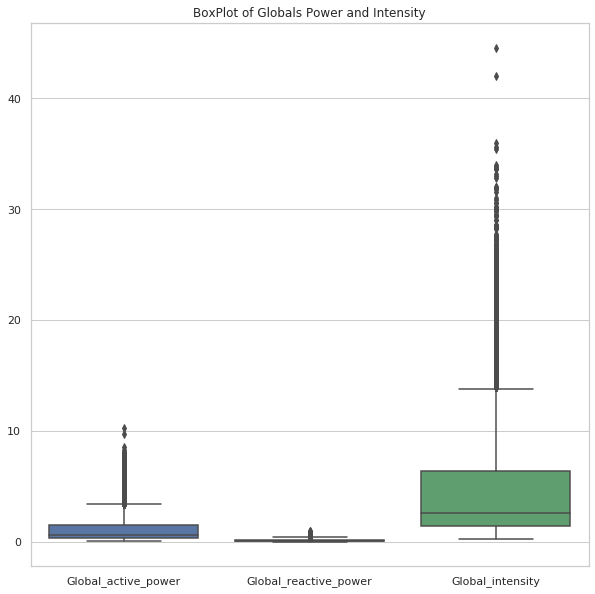

In [63]:
# BoxPlot 1

Globais = power_consumption[['Global_active_power', 'Global_reactive_power', 'Global_intensity']]

plt.figure(figsize=(10,10))
plt.title('BoxPlot of Globals Power and Intensity')
sns.set(style="whitegrid", color_codes=True)
sns.boxplot(data=Globais);

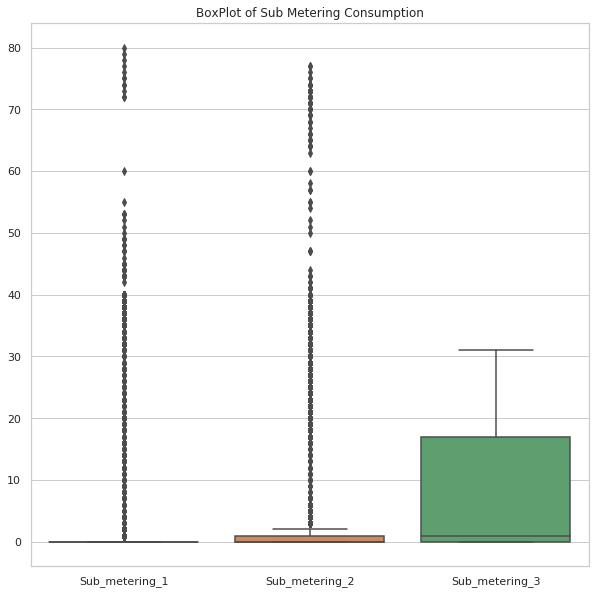

In [64]:
# BoxPlot 2

Sub_meterings = power_consumption[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

plt.figure(figsize=(10,10))
plt.title('BoxPlot of Sub Metering Consumption')
sns.set(style="whitegrid", color_codes=True)
sns.boxplot(data=Sub_meterings);

**Interessante**. Existem muitos outliers (esses pontos 'infinitos'). Vamos mantê-los para visualizarmos no gráfico.

### **MODELAGEM**

Para a resolução do negócio, será utilizado o modelo de machine learning **K-Means**.

K-Means é um método de clusterização que utiliza a distância dos diversos pontos com o pontos-centro (centróide) como métrica para separar os dados em grupos. A quantidade de grupos, e seus centróides, é definido pelo parâmetro "k". Os grupos são formados pelos dados que apresentam a menor distância com um dos centros.

Para definir o melhor "k", podemos utilizar o *elbow method* (método do cotovelo). Esse método irá testar vários clusters e encontrar a melhor quantidade de grupos.

Mas primeiro...

> **7. Principal Component Analysis**

A aplicação do **PCA** (Principal Component Analysis) é muito comum quando se tem uma alta dimensinalidade, com um extensível número de atributos. O PCA pega o largo dataset e, através das dependência entre os atributos, reduz o tamanho pela compressão do dataset sem remover de fato quaisquer atributos. Vamos determinar 2 componentes, assim poderemos visualizar graficamente a disposição dos grupos.

In [214]:
# Redução de dimensionalidade
pca = PCA(n_components=2, random_state=42, ).fit_transform(power_consumption)
pca

array([[10.13092491, -5.66977479],
       [-7.56884412,  0.91764998],
       [-5.62443002,  0.94652261],
       ...,
       [-7.32029548,  0.63527315],
       [-6.21277681,  1.53081085],
       [10.36460222, -5.31065721]])

> **8. K-Means**

> *8.a. Encontrando o melhor K com o Método Elbow*

Inicialmente foi definido um intervalo para "k" de 1 a 9. Como demonstrado no gráfico abaixo, a partir de K = 1 a inércia cai bruscamente até o K = 3. Daí em diante a tendência cai com pouca variação.

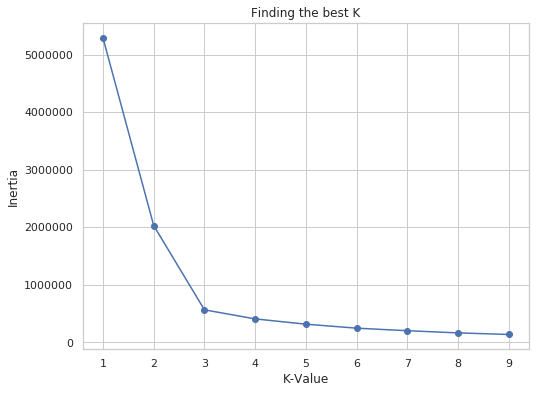

In [215]:
# Encontrar o melhor K para aplicar ao algoritmo K-Means

inertia = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca)
    inertia.append((i,kmeans.inertia_,))

# Plotar gráfico

plt.figure(figsize=(8,6))
plt.plot([k[0] for k in inertia], [k[1] for k in inertia], marker='o')

plt.title('Finding the best K')
plt.xlabel('K-Value')
plt.ylabel('Inertia')

plt.show()

 Podemos utilizar K = 3. Mas para determinando o melhor agrupamento vamos analisar as métricas de acordo com o **Silhouette Score**.

> *8.b. Silhouette Score*

O coeficiente da silhueta é calculado usando a **distância média intra-cluster** e a **distância média mais próxima do cluster para cada amostra** *(a amostra, nesse, não faz parte do cluster)*. O coeficiente para uma amostra é `(b - a) / máximo (a, b)`. Quanto mais próximo de 1, melhor. Quanto mais próximo de -1, pior *(indicando que uma amostra foi disposta em um cluster errado)*. O valor próximo a ZERO indica clusters sobrepostos.

In [216]:
ranges = [2,3,4,5,6,7]
silhouettes = []

for k in ranges:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pca)
    silhouettes_k = silhouette_score(pca, kmeans.labels_,metric='euclidean')
    silhouettes.append({'cluster': k, 'silhouette_score':round(silhouettes_k,4)})    

k_silh = pd.DataFrame(silhouettes)

# Escolha do melhor k baseado no maior valor do silhouette score
k_max_silh = k_silh.silhouette_score.max()
k_by_silh = k_silh.cluster[k_silh.silhouette_score.argmax()]

print(k_silh)
print(f'\nA quantidade de k-grupos escolhido foi {k_by_silh}, que retornou um Silhouette Score de {k_max_silh}.')

   cluster  silhouette_score
0        2            0.7903
1        3            0.8500
2        4            0.8525
3        5            0.8569
4        6            0.8466
5        7            0.8373

A quantidade de k-grupos escolhido foi 5, que retornou um Silhouette Score de 0.8569.


> *8.c. Criando o modelo K-Means*4

In [217]:
# modelo
kmeans = KMeans(n_clusters=k_by_silh, random_state=42)
kmeans.fit(pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

### **GRÁFICO**

Agora irei plotar um scatterplot para visualizarmos os 4 clusters criados e seus centróides.

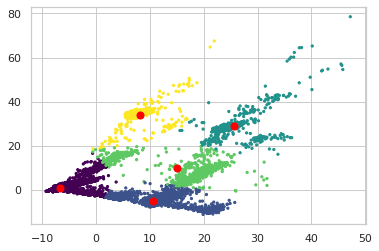

In [218]:
# Scatterplot da modelagem
y_kmeans = kmeans.predict(pca)
plt.scatter(pca[:, 0], pca[:, 1], c=y_kmeans, s=5, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='o',c='red', s=50)
plt.show()

### **ANALISANDO OS GRUPOS**

In [250]:
power_consumption['Labels'] = kmeans.labels_

grupo_um = power_consumption[power_consumption.Labels == 0]
grupo_dois = power_consumption[power_consumption.Labels == 1]
grupo_tres = power_consumption[power_consumption.Labels == 2]
grupo_quatro = power_consumption[power_consumption.Labels == 3]
grupo_cinco = power_consumption[power_consumption.Labels == 4]

groups = [grupo_um, grupo_dois, grupo_tres, grupo_quatro, grupo_cinco]

No handles with labels found to put in legend.


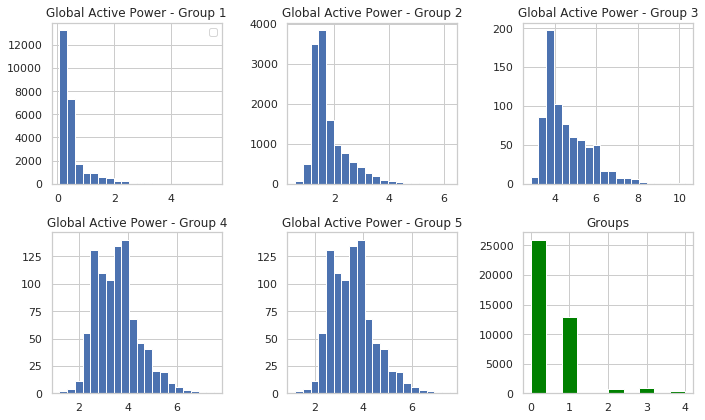

In [263]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

ax0.hist(x=grupo_um.Global_active_power, bins=20)
ax0.legend(prop={'size': 10})
ax0.set_title('Global Active Power - Group 1')

ax1.hist(x=grupo_dois.Global_active_power, bins=20)
ax1.set_title('Global Active Power - Group 2')

ax2.hist(x=grupo_tres.Global_active_power, bins=20)
ax2.set_title('Global Active Power - Group 3')

ax3.hist(x=grupo_quatro.Global_active_power, bins=20)
ax3.set_title('Global Active Power - Group 4')

ax4.hist(x=grupo_quatro.Global_active_power, bins=20)
ax4.set_title('Global Active Power - Group 5')

ax5.hist(x=power_consumption.Labels, color= 'green')
ax5.set_title('Groups')

fig.tight_layout()
plt.show()

No handles with labels found to put in legend.


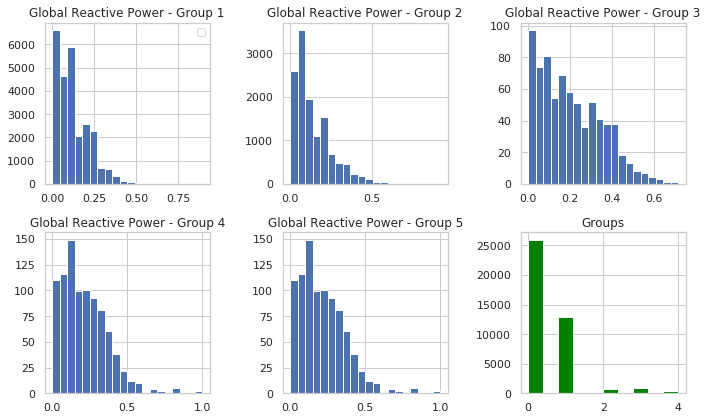

In [262]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

ax0.hist(x=grupo_um.Global_reactive_power, bins=20)
ax0.legend(prop={'size': 10})
ax0.set_title('Global Reactive Power - Group 1')

ax1.hist(x=grupo_dois.Global_reactive_power, bins=20)
ax1.set_title('Global Reactive Power - Group 2')

ax2.hist(x=grupo_tres.Global_reactive_power, bins=20)
ax2.set_title('Global Reactive Power - Group 3')

ax3.hist(x=grupo_quatro.Global_reactive_power, bins=20)
ax3.set_title('Global Reactive Power - Group 4')

ax4.hist(x=grupo_quatro.Global_reactive_power, bins=20)
ax4.set_title('Global Reactive Power - Group 5')

ax5.hist(x=power_consumption.Labels, color= 'green')
ax5.set_title('Groups')

fig.tight_layout()
plt.show()

No handles with labels found to put in legend.


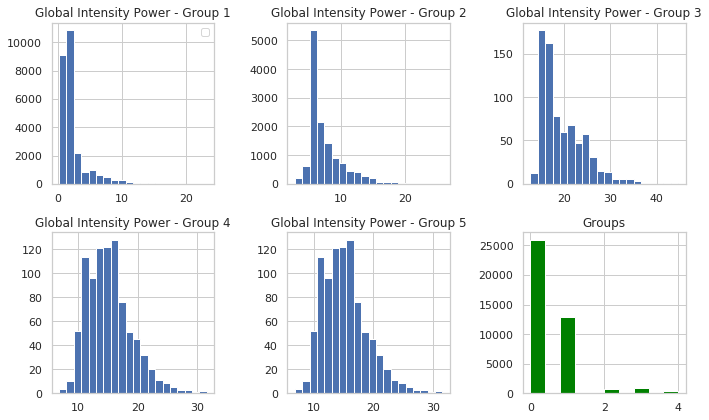

In [261]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

ax0.hist(x=grupo_um.Global_intensity, bins=20)
ax0.legend(prop={'size': 10})
ax0.set_title('Global Intensity Power - Group 1')

ax1.hist(x=grupo_dois.Global_intensity, bins=20)
ax1.set_title('Global Intensity Power - Group 2')

ax2.hist(x=grupo_tres.Global_intensity, bins=20)
ax2.set_title('Global Intensity Power - Group 3')

ax3.hist(x=grupo_quatro.Global_intensity, bins=20)
ax3.set_title('Global Intensity Power - Group 4')

ax4.hist(x=grupo_quatro.Global_intensity, bins=20)
ax4.set_title('Global Intensity Power - Group 5')

ax5.hist(x=power_consumption.Labels, color= 'green')
ax5.set_title('Groups')

fig.tight_layout()
plt.show()

No handles with labels found to put in legend.


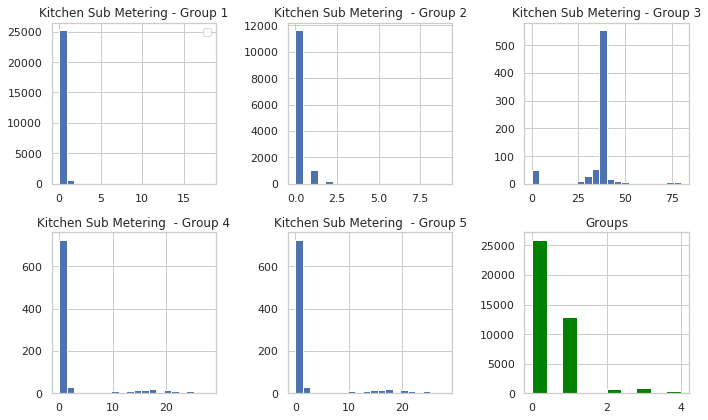

In [260]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

ax0.hist(x=grupo_um.Sub_metering_1, bins=20)
ax0.legend(prop={'size': 10})
ax0.set_title('Kitchen Sub Metering - Group 1')

ax1.hist(x=grupo_dois.Sub_metering_1, bins=20)
ax1.set_title('Kitchen Sub Metering  - Group 2')

ax2.hist(x=grupo_tres.Sub_metering_1, bins=20)
ax2.set_title('Kitchen Sub Metering - Group 3')

ax3.hist(x=grupo_quatro.Sub_metering_1, bins=20)
ax3.set_title('Kitchen Sub Metering  - Group 4')

ax4.hist(x=grupo_quatro.Sub_metering_1, bins=20)
ax4.set_title('Kitchen Sub Metering  - Group 5')

ax5.hist(x=power_consumption.Labels, color= 'green')
ax5.set_title('Groups')

fig.tight_layout()
plt.show()

No handles with labels found to put in legend.


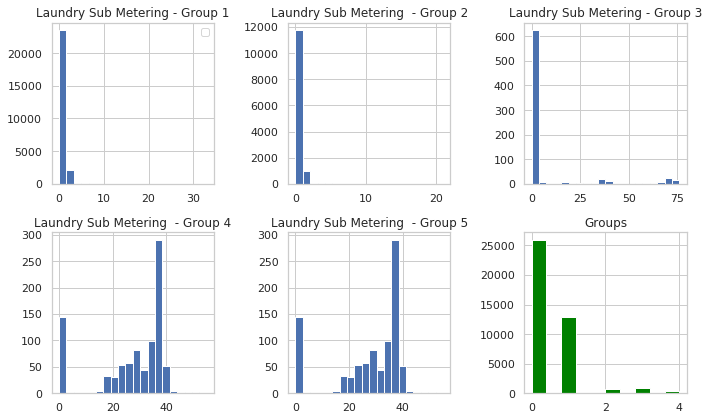

In [258]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

ax0.hist(x=grupo_um.Sub_metering_2, bins=20)
ax0.legend(prop={'size': 10})
ax0.set_title('Laundry Sub Metering - Group 1')

ax1.hist(x=grupo_dois.Sub_metering_2, bins=20)
ax1.set_title('Laundry Sub Metering  - Group 2')

ax2.hist(x=grupo_tres.Sub_metering_2, bins=20)
ax2.set_title('Laundry Sub Metering - Group 3')

ax3.hist(x=grupo_quatro.Sub_metering_2, bins=20)
ax3.set_title('Laundry Sub Metering  - Group 4')

ax4.hist(x=grupo_quatro.Sub_metering_2, bins=20)
ax4.set_title('Laundry Sub Metering  - Group 5')

ax5.hist(x=power_consumption.Labels, color= 'green')
ax5.set_title('Groups')

fig.tight_layout()
plt.show()

No handles with labels found to put in legend.


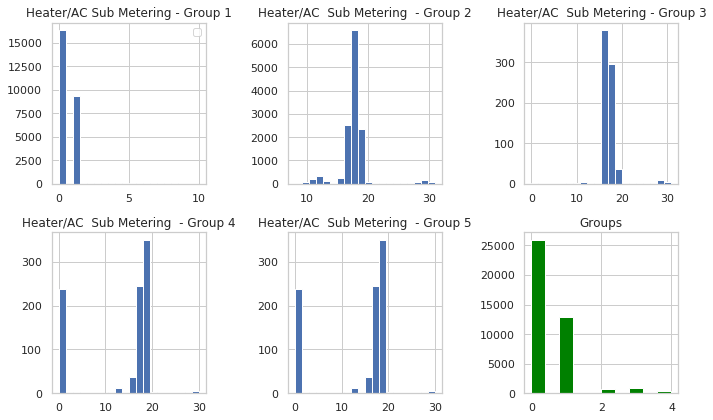

In [257]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

ax0.hist(x=grupo_um.Sub_metering_3, bins=20)
ax0.legend(prop={'size': 10})
ax0.set_title('Heater/AC Sub Metering - Group 1')

ax1.hist(x=grupo_dois.Sub_metering_3, bins=20)
ax1.set_title('Heater/AC  Sub Metering  - Group 2')

ax2.hist(x=grupo_tres.Sub_metering_3, bins=20)
ax2.set_title('Heater/AC  Sub Metering - Group 3')

ax3.hist(x=grupo_quatro.Sub_metering_3, bins=20)
ax3.set_title('Heater/AC  Sub Metering  - Group 4')

ax4.hist(x=grupo_quatro.Sub_metering_3, bins=20)
ax4.set_title('Heater/AC  Sub Metering  - Group 5')

ax5.hist(x=power_consumption.Labels, color= 'green')
ax5.set_title('Groups')

fig.tight_layout()
plt.show()

In [267]:
power_consumption['Total_Consumed'] = power_consumption['Sub_metering_1'] + power_consumption['Sub_metering_2'] + power_consumption['Sub_metering_3']

In [285]:
print('MEAN OF TOTAL ENERGY CONSUMED BY GROUP')
print('--------------------------------------')
for i in range(0,len(power_consumption.Labels.unique())):
    print(f'Mean of Group {i} =', round(power_consumption.Total_Consumed[power_consumption.Labels == i].mean(),2))
    

MEAN OF TOTAL ENERGY CONSUMED BY GROUP
--------------------------------------
Mean of Group 0 = 0.98
Mean of Group 1 = 18.49
Mean of Group 2 = 60.82
Mean of Group 3 = 43.13
Mean of Group 4 = 41.16
